## Turkish Instructions Retrieval Emsemble

In [1]:
# !pip install datasets

### Import Libraries

In [2]:
import sys
import os
import pickle

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

#### Set Path and Constant Values

In [3]:
# Set Constants

# If use Google Colab
use_colab = False
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    # ROOT_PATH = r"G:\Drive'ım\Colab Notebooks\HW3"
    ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks/HW3"
else:
    ROOT_PATH = os.getcwd()

CACHE_PATH = os.path.join(ROOT_PATH, 'cache')
DATA_PATH = os.path.join(ROOT_PATH, 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
EMBEDDING_DATA_PATH = os.path.join(DATA_PATH, 'embedding')

# Create Folders
os.makedirs(RAW_DATA_PATH, exist_ok=True)
os.makedirs(EMBEDDING_DATA_PATH, exist_ok=True)
os.makedirs(CACHE_PATH, exist_ok=True)

### Embedding Models

In [4]:
# Model embedding dosya isimleri
model_files = [
    "sentence-transformers__all-MiniLM-L12-v2",
    "jinaai__jina-embeddings-v3",
    "intfloat__multilingual-e5-large-instruct",
    "BAAI__bge-m3",
    "ytu-ce-cosmos__turkish-colbert",
    "thenlper__gte-large"
]

In [5]:
# Her modelin Top-1 ve Top-5 performanslarını saklamak için
model_results = {}

print(f"Model Name \t\t\t\t\t Top-1 Accuracy \t\t Top-5 Accuracy")
# Her model için işlemleri gerçekleştirelim
for model_name in model_files:
    # print(f"\nTop-1 ve Top-5 hesaplanıyor: {model_name}")

    # Sorular ve cevap embedding dosyalarını oku
    question_file = os.path.join(EMBEDDING_DATA_PATH, f"question_{model_name}_embeddings.csv.gz")
    answer_file = os.path.join(EMBEDDING_DATA_PATH, f"answer_{model_name}_embeddings.csv.gz")
    df_questions = pd.read_csv(question_file, compression='gzip')
    df_answers = pd.read_csv(answer_file, compression='gzip')

    # Embedding matrislerini al
    question_embeddings = df_questions.iloc[:, 1:].values  # İlk sütun (soru) metin olduğu için çıkartıyoruz
    answer_embeddings = df_answers.iloc[:, 1:].values # İlk sütun (cevap) metin olduğu için çıkartıyoruz

    # Cosine similarity hesapla
    similarity_matrix = cosine_similarity(question_embeddings, answer_embeddings)

    # Top-1 ve Top-5 doğruluğunu hesaplama
    top1_correct = 0
    top5_correct = 0

    for idx, row in enumerate(similarity_matrix):
        # Benzerlik sıralamasını al
        sorted_indices = np.argsort(row)[::-1]  # Büyükten küçüğe sıralama
        correct_answer_idx = idx  # Her sorunun doğru cevabı aynı indeksde yer alıyor

        # Top-1 doğruluğu kontrol et
        if correct_answer_idx == sorted_indices[0]:
            top1_correct += 1

        # Top-5 doğruluğu kontrol et
        if correct_answer_idx in sorted_indices[:5]:
            top5_correct += 1

    # Doğruluk oranlarını hesapla
    top1_accuracy = top1_correct / len(df_questions)
    top5_accuracy = top5_correct / len(df_questions)

    # Sonuçları kaydet
    model_results[model_name] = {
        "Top-1 Accuracy": top1_accuracy,
        "Top-5 Accuracy": top5_accuracy
    }
    # print(f"{model_name} - Top-1 Accuracy: {top1_accuracy:.4f}, Top-5 Accuracy: {top5_accuracy:.4f}")
    print(f"{model_name:<50} {top1_accuracy:<30.4f} {top5_accuracy:<30.4f}")

Model Name 					 Top-1 Accuracy 		 Top-5 Accuracy
sentence-transformers__all-MiniLM-L12-v2           0.2865                         0.4025                        
jinaai__jina-embeddings-v3                         0.8495                         0.9235                        
intfloat__multilingual-e5-large-instruct           0.6705                         0.8075                        
BAAI__bge-m3                                       0.7600                         0.8575                        
ytu-ce-cosmos__turkish-colbert                     0.3470                         0.5005                        
thenlper__gte-large                                0.3855                         0.5285                        


Model Performans Sonuçları:
       Model  Top-1 Accuracy  Top-5 Accuracy
0     MiniLM          0.2865          0.4025
1       Jina          0.8495          0.9235
2   E5-Large          0.6705          0.8075
3     BGE-M3          0.7600          0.8575
4    ColBERT          0.3470          0.5005
5  GTE Large          0.3855          0.5285


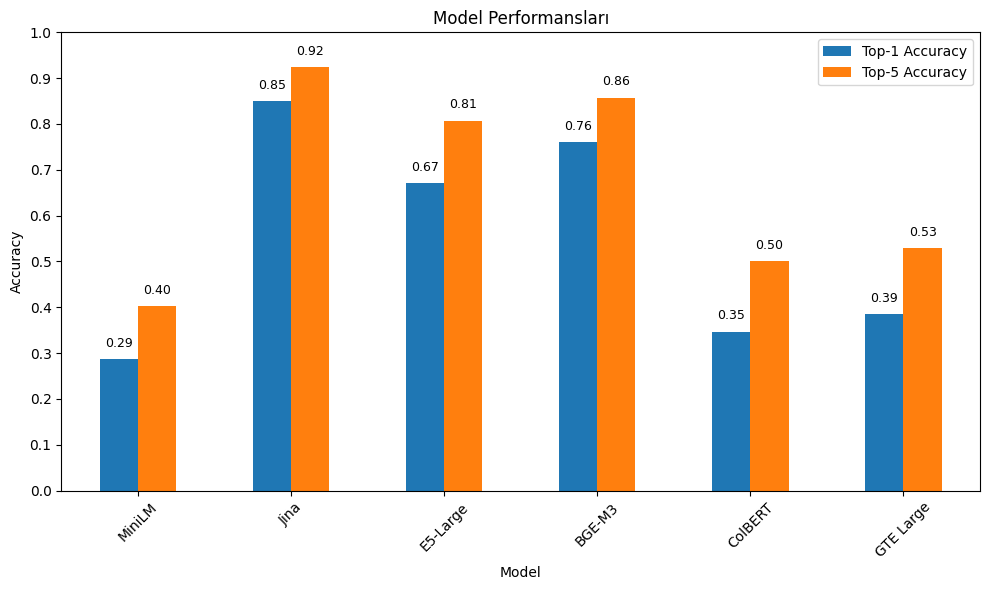

In [6]:
# Model isimlerini kısalt
model_name_mapping = {
    "sentence-transformers__all-MiniLM-L12-v2": "MiniLM",
    "jinaai__jina-embeddings-v3": "Jina",
    "intfloat__multilingual-e5-large-instruct": "E5-Large",
    "BAAI__bge-m3": "BGE-M3",
    "ytu-ce-cosmos__turkish-colbert": "ColBERT",
    "thenlper__gte-large": "GTE Large"
}

# Sonuçları tabloya dönüştür
results_df = pd.DataFrame(model_results).T  # Transpose yaparak modelleri satır haline getir
results_df.reset_index(inplace=True)
results_df.rename(columns={"index": "Model"}, inplace=True)

# Model isimlerini kısalt
results_df['Model'] = results_df['Model'].map(model_name_mapping)

# Tabloyu görüntüle
print("Model Performans Sonuçları:")
print(results_df)

# Bar Grafik Çizimi
ax = results_df.plot(
    x="Model",
    y=["Top-1 Accuracy", "Top-5 Accuracy"],
    kind="bar",
    figsize=(10, 6),
    legend=True
)

# Başlık ve Etiketler
plt.title("Model Performansları")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.yticks(np.arange(0.0, 1.1, 0.1))

# Barların üzerinde değerleri ekle
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=9
        )

# Grafik göster
plt.tight_layout()
plt.show()

In [7]:
df_sample = pd.read_csv(os.path.join(RAW_DATA_PATH, "sampled_turkish_instructions.csv"))

In [8]:
# Örnek bir soru için indeks seç
example_question_index = 0
example_question_text = df_sample.iloc[example_question_index]['soru']
example_correct_answer = df_sample.iloc[example_question_index]['cevap']

# Her model için cevap adaylarını göster
print(f"Örnek Soru: {example_question_text}")
print(f"Gerçek Cevap: {example_correct_answer}\n")

for model_name in model_files:
    print(f"Model: {model_name}")

    # Sorular ve cevap embedding dosyalarını oku
    question_file = os.path.join(EMBEDDING_DATA_PATH, f"question_{model_name}_embeddings.csv.gz")
    answer_file = os.path.join(EMBEDDING_DATA_PATH, f"answer_{model_name}_embeddings.csv.gz")
    df_questions = pd.read_csv(question_file, compression='gzip')
    df_answers = pd.read_csv(answer_file, compression='gzip')

    # Örnek sorunun embedding'ini al
    question_embedding = df_questions.iloc[example_question_index, 1:].values.reshape(1, -1)

    # Cevap embedding'leri ile cosine similarity hesapla
    answer_embeddings = df_answers.iloc[:, 1:].values
    similarity_scores = cosine_similarity(question_embedding, answer_embeddings).flatten()

    # Benzerlik skorlarına göre sıralama yap
    sorted_indices = np.argsort(similarity_scores)[::-1]
    top5_indices = sorted_indices[:5]

    # İlk 5 cevabı göster
    print("Top-5 Cevap Adayları:")
    for rank, idx in enumerate(top5_indices, 1):
        candidate_answer = df_sample.iloc[idx]['cevap']
        similarity_score = similarity_scores[idx]
        print(f"  {rank}. [{similarity_score:.4f}] {candidate_answer}")

    # Top-1 cevabı göster
    top1_index = sorted_indices[0]
    top1_candidate = df_sample.iloc[top1_index]['cevap']
    print(f"\nTop-1 Cevap: [{similarity_scores[top1_index]:.4f}] {top1_candidate}\n")
    print("-" * 40)


Örnek Soru:  Belirli bir konu hakkında bir makale yazın. Konu: Zaman Yönetimi
Gerçek Cevap: Zaman yönetimi, hayatta başarılı olmak için sahip olunması gereken önemli bir beceridir. Gününüzden en iyi şekilde yararlanabilmeniz için görevlere öncelik vermenizi ve zamanınızı en iyi şekilde değerlendirmenizi sağlar. Etkili zaman yönetimine sahip olmak aynı zamanda odaklanmanıza ve doğru yolda kalmanıza yardımcı olur ve ertelemeyi önler. Zamanınızı etkili bir şekilde yönetmenin bir yolu, bir program oluşturmak ve ona bağlı kalmaktır. Günün belirli saatlerini belirli etkinliklere ayırmanız ve bu saatlere saygı duymanız önemlidir. Örneğin spor yapmak istiyorsanız her gün aynı saatte bir saat ayırın ve o randevuya mutlaka uyun. Görevleriniz için ulaşılabilir hedefler ve zaman çizelgesi belirlediğinizden de emin olmalısınız. Bunu yaparak, daha büyük görevleri yönetilebilir parçalara ayırabilir ve odaklanmanızı ve motive olmanızı sağlayacak somut hedeflere ve teslim tarihlerine sahip olabilirsini

In [9]:
# Örnek bir soru için similarity skorlarını kontrol et
example_question_index = 0
question_embedding = df_questions.iloc[example_question_index, 1:].values.reshape(1, -1)
similarity_scores = cosine_similarity(question_embedding, answer_embeddings).flatten()

# Skorların sıralanması
sorted_indices = np.argsort(similarity_scores)[::-1]
print("Cosine Similarity Scores (sorted):", similarity_scores[sorted_indices][:10])  # İlk 10 cevabı göster cosign similatiry .4f olarak ifade et
print("Top-5 Indices:", sorted_indices[:5])  # İlk 5 indeks

Cosine Similarity Scores (sorted): [0.91860757 0.91023453 0.90168125 0.90031453 0.89795692 0.89718304
 0.89662276 0.89611995 0.89387621 0.89358594]
Top-5 Indices: [1435    0  794 1329  394]


In [10]:
print(f"Correct Answer Index: {correct_answer_idx}")
print(f"Top-1 Index: {sorted_indices[0]}")
print(f"Top-5 Indices: {sorted_indices[:5]}")
print(f"Is Top-1 Correct? {correct_answer_idx == sorted_indices[0]}")
print(f"Is Top-5 Correct? {correct_answer_idx in sorted_indices[:5]}")

Correct Answer Index: 1999
Top-1 Index: 1435
Top-5 Indices: [1435    0  794 1329  394]
Is Top-1 Correct? False
Is Top-5 Correct? False


In [16]:
print(f"Similarity Matrix Shape:{similarity_matrix.shape}")

Similarity Matrix Shape:(2000, 2000)


In [ ]:
# Tüm modeller ve tüm sorular için doğruluk kontrolü
for model_name in model_files:
    print(f"\nKontrol Ediliyor: {model_name}")

    # Sorular ve cevap embedding dosyalarını oku
    question_file = os.path.join(EMBEDDING_DATA_PATH, f"question_{model_name}_embeddings.csv.gz")
    answer_file = os.path.join(EMBEDDING_DATA_PATH, f"answer_{model_name}_embeddings.csv.gz")
    df_questions = pd.read_csv(question_file, compression='gzip')
    df_answers = pd.read_csv(answer_file, compression='gzip')

    # Embedding matrislerini al
    question_embeddings = df_questions.iloc[:, 1:].values
    answer_embeddings = df_answers.iloc[:, 1:].values

    # Cosine similarity hesapla
    similarity_matrix = cosine_similarity(question_embeddings, answer_embeddings)

    # Top-1 ve Top-5 kontrolü
    for idx, row in enumerate(similarity_matrix):
        sorted_indices = np.argsort(row)[::-1]  # Büyükten küçüğe sıralama
        correct_answer_idx = idx  # Her sorunun doğru cevabı aynı indekste yer alıyor

        # Kontrol detayları
        top1_index = sorted_indices[0]
        top5_indices = sorted_indices[:5]

        if correct_answer_idx != top1_index:
            print(f"Top-1 Hata: Soru-{idx}, Doğru Cevap: {df_sample.iloc[correct_answer_idx]['cevap']}, "
                  f"Top-1 Cevap: {df_sample.iloc[top1_index]['cevap']}")

        if correct_answer_idx not in top5_indices:
            print(f"Top-5 Hata: Soru-{idx}, Doğru Cevap: {df_sample.iloc[correct_answer_idx]['cevap']}, "
                  f"Top-5 Cevaplar: {[df_sample.iloc[i]['cevap'] for i in top5_indices]}")

In [17]:
# Tüm modeller için Top-1 ve Top-5 hatalı tahmin sayılarını saklamak için sözlük
error_counts = {}

for model_name in model_files:
    # Sorular ve cevap embedding dosyalarını oku
    question_file = os.path.join(EMBEDDING_DATA_PATH, f"question_{model_name}_embeddings.csv.gz")
    answer_file = os.path.join(EMBEDDING_DATA_PATH, f"answer_{model_name}_embeddings.csv.gz")
    df_questions = pd.read_csv(question_file, compression='gzip')
    df_answers = pd.read_csv(answer_file, compression='gzip')

    # Embedding matrislerini al
    question_embeddings = df_questions.iloc[:, 1:].values
    answer_embeddings = df_answers.iloc[:, 1:].values

    # Cosine similarity hesapla
    similarity_matrix = cosine_similarity(question_embeddings, answer_embeddings)

    # Hata sayacı
    top1_errors = 0
    top5_errors = 0

    # Top-1 ve Top-5 kontrolü
    for idx, row in enumerate(similarity_matrix):
        sorted_indices = np.argsort(row)[::-1]  # Büyükten küçüğe sıralama
        correct_answer_idx = idx  # Her sorunun doğru cevabı aynı indekste yer alıyor

        # Top-1 hatası
        if correct_answer_idx != sorted_indices[0]:
            top1_errors += 1

        # Top-5 hatası
        if correct_answer_idx not in sorted_indices[:5]:
            top5_errors += 1
    
    # Toplam soru sayısı
    total_questions = len(similarity_matrix)

    # Hata sayılarını ve yüzdelerini kaydet
    error_counts[model_name] = {
        "Top-1 Errors": top1_errors,
        "Top-1 Error %": (top1_errors / total_questions) * 100,
        "Top-5 Errors": top5_errors,
        "Top-5 Error %": (top5_errors / total_questions) * 100
    }

# Hata sayılarını yazdır
print("Model Bazlı Hatalı Tahmin Sayıları ve Yüzdeleri:\n")
for model, errors in error_counts.items():
    print(f"\nModel: {model}")
    print(f"  Top-1 Hatalı Tahminler: {errors['Top-1 Errors']} ({errors['Top-1 Error %']:.2f} %)")
    print(f"  Top-5 Hatalı Tahminler: {errors['Top-5 Errors']} ({errors['Top-5 Error %']:.2f} %)")

Model Bazlı Hatalı Tahmin Sayıları ve Yüzdeleri:


Model: sentence-transformers__all-MiniLM-L12-v2
  Top-1 Hatalı Tahminler: 1427 (71.35 %)
  Top-5 Hatalı Tahminler: 1195 (59.75 %)

Model: jinaai__jina-embeddings-v3
  Top-1 Hatalı Tahminler: 301 (15.05 %)
  Top-5 Hatalı Tahminler: 153 (7.65 %)

Model: intfloat__multilingual-e5-large-instruct
  Top-1 Hatalı Tahminler: 659 (32.95 %)
  Top-5 Hatalı Tahminler: 385 (19.25 %)

Model: BAAI__bge-m3
  Top-1 Hatalı Tahminler: 480 (24.00 %)
  Top-5 Hatalı Tahminler: 285 (14.25 %)

Model: ytu-ce-cosmos__turkish-colbert
  Top-1 Hatalı Tahminler: 1306 (65.30 %)
  Top-5 Hatalı Tahminler: 999 (49.95 %)

Model: thenlper__gte-large
  Top-1 Hatalı Tahminler: 1229 (61.45 %)
  Top-5 Hatalı Tahminler: 943 (47.15 %)


In [18]:
# Pickle dosyasının kaydedileceği yol
cosine_similarity_file = ROOT_PATH + "/cosine_similarity_data.pkl"

# Eğer daha önce kaydedilmiş dosya varsa yükle, yoksa hesapla
if os.path.exists(cosine_similarity_file):
    with open(cosine_similarity_file, "rb") as f:
        cosine_similarity_data = pickle.load(f)
    print("Daha önce kaydedilmiş cosine similarity verileri yüklendi.")
else:
    # Yeni hesaplama için boş bir veri yapısı
    cosine_similarity_data = {}

    for model_name in model_files:
        print(f"\nCosine similarity hesaplanıyor: {model_name}")

        # Sorular ve cevap embedding dosyalarını oku
        question_file = os.path.join(EMBEDDING_DATA_PATH, f"question_{model_name}_embeddings.csv.gz")
        answer_file = os.path.join(EMBEDDING_DATA_PATH, f"answer_{model_name}_embeddings.csv.gz")
        df_questions = pd.read_csv(question_file, compression='gzip')
        df_answers = pd.read_csv(answer_file, compression='gzip')

        # Tüm sorular ve cevaplar için cosine similarity hesapla
        question_embeddings = df_questions.iloc[:, 1:].values
        answer_embeddings = df_answers.iloc[:, 1:].values
        similarity_matrix = cosine_similarity(question_embeddings, answer_embeddings)

        # Hesaplanan similarity matrisini kaydet
        cosine_similarity_data[model_name] = similarity_matrix
        print(f"{model_name} için cosine similarity hesaplandı ve saklandı.")

    # Pickle ile kaydet
    with open(cosine_similarity_file, "wb") as f:
        pickle.dump(cosine_similarity_data, f)
    print("Cosine similarity verileri pickle dosyasına kaydedildi.")


Cosine similarity hesaplanıyor: sentence-transformers__all-MiniLM-L12-v2
sentence-transformers__all-MiniLM-L12-v2 için cosine similarity hesaplandı ve saklandı.

Cosine similarity hesaplanıyor: jinaai__jina-embeddings-v3
jinaai__jina-embeddings-v3 için cosine similarity hesaplandı ve saklandı.

Cosine similarity hesaplanıyor: intfloat__multilingual-e5-large-instruct
intfloat__multilingual-e5-large-instruct için cosine similarity hesaplandı ve saklandı.

Cosine similarity hesaplanıyor: BAAI__bge-m3
BAAI__bge-m3 için cosine similarity hesaplandı ve saklandı.

Cosine similarity hesaplanıyor: ytu-ce-cosmos__turkish-colbert
ytu-ce-cosmos__turkish-colbert için cosine similarity hesaplandı ve saklandı.

Cosine similarity hesaplanıyor: thenlper__gte-large
thenlper__gte-large için cosine similarity hesaplandı ve saklandı.
Cosine similarity verileri pickle dosyasına kaydedildi.


In [20]:
# Pickle dosyasını yükle
with open(cosine_similarity_file, "rb") as f:
    cosine_similarity_data = pickle.load(f)

# Ensemble sonuçlarını saklamak için
ensemble_results = {
    "Majority Voting": {"Top-1": 0, "Top-5": 0},
    "Average Cosine": {"Top-1": 0, "Top-5": 0},
    "Weighted Average": {"Top-1": 0, "Top-5": 0}
}

model_weights = {
    "sentence-transformers__all-MiniLM-L12-v2": 0.314,  # MiniLM doğruluk oranı
    "jinaai__jina-embeddings-v3": 0.861,  # Jina doğruluk oranı
    "intfloat__multilingual-e5-large-instruct": 0.660,  # E5-Large doğruluk oranı
    "BAAI__bge-m3": 0.765,  # BGE-M3 doğruluk oranı
    "ytu-ce-cosmos__turkish-colbert": 0.351,  # ColBERT doğruluk oranı
    "thenlper__gte-large": 0.413
}

# Ensemble hesaplama
for idx in range(len(df_sample)):
    #print(f"İşleniyor: Soru-{idx + 1}/{len(df_sample)}")

    # Her modelin similarity skorlarını ve sıralamalarını sakla
    all_similarities = []
    all_top5_candidates = []

    for model_name, similarity_matrix in cosine_similarity_data.items():
        row = similarity_matrix[idx]  # İlgili sorunun tüm cevaplarla benzerlik skorları
        sorted_indices = np.argsort(row)[::-1]

        # Top-5 adayları ve skorları
        all_top5_candidates.append(sorted_indices[:5])
        all_similarities.append(row)

    # Gerçek cevap indeksi
    correct_answer_idx = idx

    # Ensemble 1: Majority Voting
    from collections import Counter
    flattened_top5 = [idx for sublist in all_top5_candidates for idx in sublist]
    most_common = Counter(flattened_top5).most_common(1)[0][0]  # En sık geçen cevap
    if most_common == correct_answer_idx:
        ensemble_results["Majority Voting"]["Top-1"] += 1
    if correct_answer_idx in Counter(flattened_top5).keys():
        ensemble_results["Majority Voting"]["Top-5"] += 1

    # Ensemble 2: Average Cosine Similarity
    avg_scores = np.mean(all_similarities, axis=0)
    avg_sorted_indices = np.argsort(avg_scores)[::-1]
    if avg_sorted_indices[0] == correct_answer_idx:
        ensemble_results["Average Cosine"]["Top-1"] += 1
    if correct_answer_idx in avg_sorted_indices[:5]:
        ensemble_results["Average Cosine"]["Top-5"] += 1

    # Ensemble 3: Weighted Average
    weighted_scores = sum(
        model_weights[model_files[i]] * all_similarities[i] for i in range(len(model_files))
    )
    weighted_sorted_indices = np.argsort(weighted_scores)[::-1]
    if weighted_sorted_indices[0] == correct_answer_idx:
        ensemble_results["Weighted Average"]["Top-1"] += 1
    if correct_answer_idx in weighted_sorted_indices[:5]:
        ensemble_results["Weighted Average"]["Top-5"] += 1

# Ensemble doğruluk oranlarını hesapla
for method, results in ensemble_results.items():
    results["Top-1 Accuracy"] = results["Top-1"] / len(df_sample)
    results["Top-5 Accuracy"] = results["Top-5"] / len(df_sample)

# Sonuçları yazdır
print("Ensemble Performans Sonuçları:")
for method, results in ensemble_results.items():
    print(f"{method}: Top-1 Accuracy: {results['Top-1 Accuracy']:.4f}, Top-5 Accuracy: {results['Top-5 Accuracy']:.4f}")

Ensemble Performans Sonuçları:
Majority Voting: Top-1 Accuracy: 0.7175, Top-5 Accuracy: 0.9365
Average Cosine: Top-1 Accuracy: 0.7760, Top-5 Accuracy: 0.8700
Weighted Average: Top-1 Accuracy: 0.8195, Top-5 Accuracy: 0.9045


In [21]:
from collections import Counter

# Pickle dosyasını yükle
with open("cosine_similarity_data.pkl", "rb") as f:
    cosine_similarity_data = pickle.load(f)

# Örnek soru indeksi
example_question_index = 0  # İlk soru (istediğiniz indeksi burada değiştirebilirsiniz)

# Gerçek soruyu ve cevabı kontrol et
example_question = df_sample.iloc[example_question_index]['soru']
correct_answer = df_sample.iloc[example_question_index]['cevap']

print(f"Örnek Soru: {example_question}")
print(f"Gerçek Cevap: {correct_answer}\n")

# Her modelin Top-5 adaylarını ve cosine similarity skorlarını sakla
all_similarities = []
all_top5_candidates = []

for model_name, similarity_matrix in cosine_similarity_data.items():
    row = similarity_matrix[example_question_index]  # Örnek sorunun tüm cevaplarla benzerlik skorları
    sorted_indices = np.argsort(row)[::-1]  # Skorları büyükten küçüğe sırala

    # Top-5 adayları ve skorları
    all_top5_candidates.append(sorted_indices[:5])
    all_similarities.append(row)

# Ensemble 1: Majority Voting (Top-1 ve Top-5)
flattened_top5 = [idx for sublist in all_top5_candidates for idx in sublist]
most_common = Counter(flattened_top5).most_common(1)[0][0]  # En sık geçen cevap
ensemble_majority_voting = df_sample.iloc[most_common]['cevap']
majority_top5 = [item[0] for item in Counter(flattened_top5).most_common(5)]

# Ensemble 2: Average Cosine Similarity (Top-1 ve Top-5)
avg_scores = np.mean(all_similarities, axis=0)
avg_sorted_indices = np.argsort(avg_scores)[::-1]
ensemble_avg_cosine = df_sample.iloc[avg_sorted_indices[0]]['cevap']
average_top5 = avg_sorted_indices[:5]

# Ensemble 3: Weighted Average (Top-1 ve Top-5)
model_weights = {
    "sentence-transformers__all-MiniLM-L12-v2": 3.14,  # MiniLM doğruluk oranı
    "jinaai__jina-embeddings-v3": 8.61,  # Jina doğruluk oranı
    "intfloat__multilingual-e5-large-instruct": 6.60,  # E5-Large doğruluk oranı
    "BAAI__bge-m3": 7.65,  # BGE-M3 doğruluk oranı
    "ytu-ce-cosmos__turkish-colbert": 3.51,  # ColBERT doğruluk oranı
    "thenlper__gte-large": 4.13
}
weighted_scores = sum(
    model_weights[list(cosine_similarity_data.keys())[i]] * all_similarities[i] for i in range(len(all_similarities))
)
weighted_sorted_indices = np.argsort(weighted_scores)[::-1]
ensemble_weighted_avg = df_sample.iloc[weighted_sorted_indices[0]]['cevap']
weighted_top5 = weighted_sorted_indices[:5]

# Sonuçları yazdır
print("Ensemble Yöntemlerinin Top-1 Cevapları:")
print("\nMajority Voting Cevabı:")
print(f"  [Frekans: {Counter(flattened_top5)[most_common]}] {ensemble_majority_voting}")

print("\nAverage Cosine Similarity Cevabı:")
print(f"  [Benzerlik (Avg): {avg_scores[avg_sorted_indices[0]]:.4f}] {ensemble_avg_cosine}")

print("\nWeighted Average Cevabı:")
print(f"  [Benzerlik (Weighted): {weighted_scores[weighted_sorted_indices[0]]:.4f}] {ensemble_weighted_avg}\n")

print("Ensemble Yöntemlerinin Top-5 Cevapları ve Skorları:")

# Majority Voting
print("\nMajority Voting Top-5 Cevaplar:")
for rank, idx in enumerate(majority_top5, 1):
    print(f"  {rank}. [Frekans: {Counter(flattened_top5)[idx]}] {df_sample.iloc[idx]['cevap']}")

# Average Cosine Similarity
print("\nAverage Cosine Top-5 Cevaplar:")
for rank, idx in enumerate(average_top5, 1):
    print(f"  {rank}. [Benzerlik (Avg): {avg_scores[idx]:.4f}] {df_sample.iloc[idx]['cevap']}")

# Weighted Average
print("\nWeighted Average Top-5 Cevaplar:")
for rank, idx in enumerate(weighted_top5, 1):
    print(f"  {rank}. [Benzerlik (Weighted): {weighted_scores[idx]:.4f}] {df_sample.iloc[idx]['cevap']}")

Örnek Soru:  Belirli bir konu hakkında bir makale yazın. Konu: Zaman Yönetimi
Gerçek Cevap: Zaman yönetimi, hayatta başarılı olmak için sahip olunması gereken önemli bir beceridir. Gününüzden en iyi şekilde yararlanabilmeniz için görevlere öncelik vermenizi ve zamanınızı en iyi şekilde değerlendirmenizi sağlar. Etkili zaman yönetimine sahip olmak aynı zamanda odaklanmanıza ve doğru yolda kalmanıza yardımcı olur ve ertelemeyi önler. Zamanınızı etkili bir şekilde yönetmenin bir yolu, bir program oluşturmak ve ona bağlı kalmaktır. Günün belirli saatlerini belirli etkinliklere ayırmanız ve bu saatlere saygı duymanız önemlidir. Örneğin spor yapmak istiyorsanız her gün aynı saatte bir saat ayırın ve o randevuya mutlaka uyun. Görevleriniz için ulaşılabilir hedefler ve zaman çizelgesi belirlediğinizden de emin olmalısınız. Bunu yaparak, daha büyük görevleri yönetilebilir parçalara ayırabilir ve odaklanmanızı ve motive olmanızı sağlayacak somut hedeflere ve teslim tarihlerine sahip olabilirsini

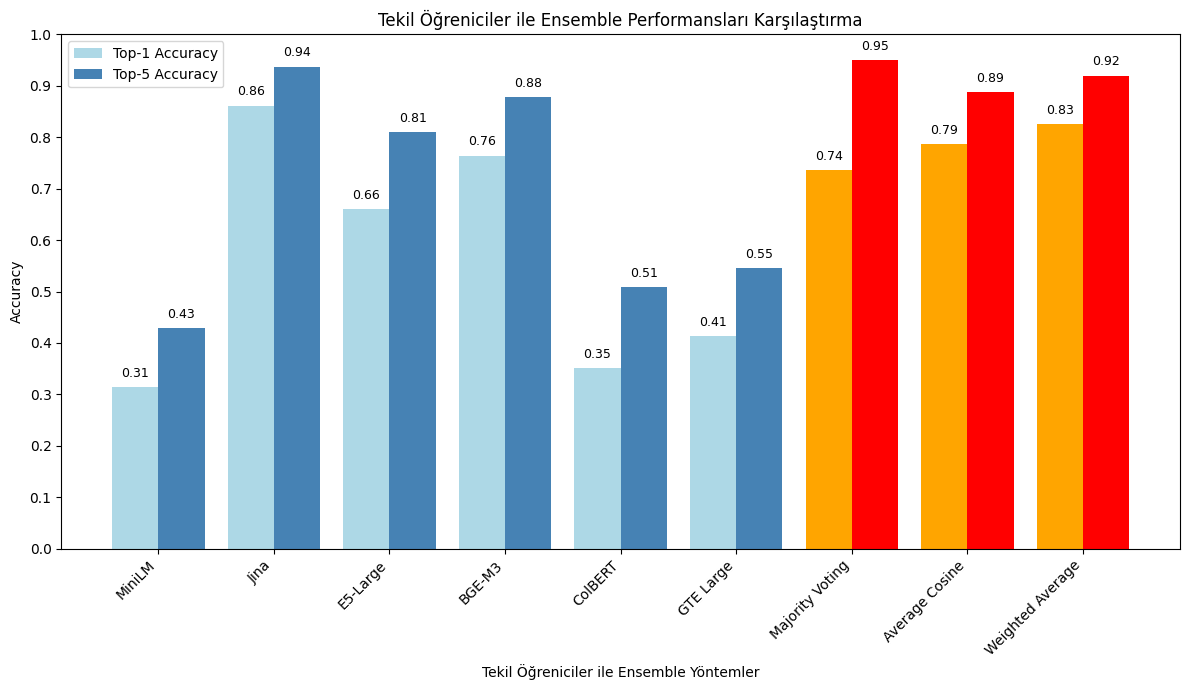

In [22]:
# Tekil modellerin başarıları
model_names = ["MiniLM", "Jina", "E5-Large", "BGE-M3", "ColBERT", "GTE Large"]
top1_accuracies = [0.3140, 0.8615, 0.6605, 0.7645, 0.3515, 0.4130]
top5_accuracies = [0.4290, 0.9375, 0.8105, 0.8785, 0.5080, 0.5450]

# Ensemble yöntemlerinin başarıları
ensemble_methods = ["Majority Voting", "Average Cosine", "Weighted Average"]
ensemble_top1 = [0.7360, 0.7860, 0.8260]
ensemble_top5 = [0.9500, 0.8875, 0.9200]

# Verileri birleştir
x_labels = model_names + ensemble_methods
top1_combined = top1_accuracies + ensemble_top1
top5_combined = top5_accuracies + ensemble_top5

# X ekseni için pozisyonlar
x = np.arange(len(x_labels))

# Bar genişliği
bar_width = 0.4

# Farklı renkler için ayarlar
colors_top1 = ['lightblue'] * len(model_names) + ['orange', 'orange', 'orange']
colors_top5 = ['steelblue'] * len(model_names) + ['red', 'red', 'red']

# Grafik oluştur
plt.figure(figsize=(12, 7))

# Top-1 doğrulukları çizin
bars1 = plt.bar(x - bar_width / 2, top1_combined, bar_width, label="Top-1 Accuracy", color=colors_top1)

# Top-5 doğrulukları çizin
bars2 = plt.bar(x + bar_width / 2, top5_combined, bar_width, label="Top-5 Accuracy", color=colors_top5)

# Barların üzerinde değerleri ekleyin
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{bar.get_height():.2f}", ha='center', fontsize=9)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{bar.get_height():.2f}", ha='center', fontsize=9)

# Etiketler ve başlık
plt.xticks(x, x_labels, rotation=45, ha="right")
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.xlabel("Tekil Öğreniciler ile Ensemble Yöntemler")
plt.ylabel("Accuracy")
plt.title("Tekil Öğreniciler ile Ensemble Performansları Karşılaştırma")
plt.ylim(0, 1)
plt.legend()

# Göster
plt.tight_layout()
plt.show()